In [1]:
import tensorflow
import matplotlib
import seaborn
import numpy
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.14.0
3.7.1
0.12.2
1.23.5
1.5.3
1.2.2


# 진행방향
---
# 1. 모든 단어 사용

`(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)`

---
# 2. 빈도수 상위 5,000개의 단어만 사용

`(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)`

---
# 3. 직접 단어 개수를 설정해서 사용

위 단계에서 5000으로 제시된 num_words를 다양하게 바꾸어 가며 성능을 확인해보세요. 변화된 단어 수에 따른 모델의 성능을 연구해 보세요. 최소 3가지 경우 이상을 실험해 보기를 권합니다.

> 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅

# 4. 딥러닝 모델과 비교해 보기
---
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정 분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.



# 평가문항	상세기준
1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
  - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
  - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
  - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

# 목차


In [2]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산


In [46]:
# 데이터 호출 및 가공
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.datasets import reuters
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 인덱스 수정을 위한 전처리
index_to_word = { index+3 : word for word, index in word_index.items() }
dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()


# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token
print('=3')

# 데이터 전처리를 위한 가공함수 생성
def data_tfidf(num_words):
  (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words= num_words, test_split=0.2)

  # #decoding
  decode_train = []
  decode_test = []

  for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decode_train.append(t)

  for i in range(len(x_test)):
    q = ' '.join([index_to_word[index] for index in x_test[i]])
    decode_test.append(q)

  x_train = decode_train
  x_test = decode_test


  x_train_dtm = dtmvector.fit_transform(x_train) #dtm 행렬 생성
  tfidfv = tfidf_transformer.fit_transform(x_train_dtm) #tf-idf 행렬 생성

  x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
  tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

  return x_train, y_train, x_test, y_test, tfidfv, tfidfv_test

=3


In [47]:
input_num = 5000 # 단어 빈도수 설정

x_train = data_tfidf(input_num)[0]
y_train = data_tfidf(input_num)[1]
x_test = data_tfidf(input_num)[2]
y_test = data_tfidf(input_num)[3]
tfidfv = data_tfidf(input_num)[4]
tfidfv_test = data_tfidf(input_num)[5]

In [73]:
print(tfidfv.shape)
print(tfidfv_test.shape)

(8982, 4867)
(2246, 4867)


In [76]:
mb = MultinomialNB()
cb = ComplementNB()
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000) #로지스틱 회귀
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False) #선형 svm
tree = DecisionTreeClassifier(max_depth=10, random_state=0) # dicision tree
forest = RandomForestClassifier(n_estimators=5, random_state=0)#randomforest
grbt = GradientBoostingClassifier(random_state=0) #gradientboosting verbose=3
voting = VotingClassifier(estimators=[('lr', lr), ('cb', cb), ('grbt', grbt)], voting='soft') # voting

In [101]:
from tqdm import tqdm

ml_lst = [mb, cb, lr, lsvc, tree, forest, grbt, voting]

precision = []
recall = []
f1_score = []


for i in ml_lst:
  print(str(i))
  tqdm(i.fit(tfidfv, y_train))
  predicted = i.predict(tfidfv_test) #테스트 데이터에 대한 예측
  # print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
  df = pd.DataFrame(classification_report(y_test, i.predict(tfidfv_test), zero_division=0, output_dict=True)).transpose()
  precision.append(df['precision'].values.tolist())
  recall.append(df['recall'].values.tolist())
  f1_score.append(df['f1-score'].values.tolist())

MultinomialNB()


0it [00:00, ?it/s]


ComplementNB()


0it [00:00, ?it/s]

LogisticRegression(C=10000, max_iter=3000)



0it [00:00, ?it/s]


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
0it [00:00, ?it/s]


DecisionTreeClassifier(max_depth=10, random_state=0)


0it [00:00, ?it/s]


RandomForestClassifier(n_estimators=5, random_state=0)


  0%|          | 0/5 [00:00<?, ?it/s]


GradientBoostingClassifier(random_state=0)


  0%|          | 0/100 [00:00<?, ?it/s]


VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')


0it [00:00, ?it/s]


# DL

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [106]:
input_num = 5000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=input_num, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_test_non = y_test

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_test_non

array([ 3, 10,  1, ...,  3,  3, 24])

In [108]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model_5000 = Sequential()
model_5000.add(Embedding(input_num, embedding_dim))
model_5000.add(LSTM(hidden_units))
model_5000.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_5000.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_5000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model_5000.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6268 - acc: 0.3527
Epoch 1: val_acc improved from -inf to 0.46037, saving model to best_model_5000.h5
71/71 [==============================] - 32s 388ms/step - loss: 2.6268 - acc: 0.3527 - val_loss: 2.2603 - val_acc: 0.4604
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 2.0620 - acc: 0.4869
Epoch 2: val_acc improved from 0.46037 to 0.51959, saving model to best_model_5000.h5
71/71 [==============================] - 33s 463ms/step - loss: 2.0620 - acc: 0.4869 - val_loss: 1.9424 - val_acc: 0.5196
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.8125 - acc: 0.5337
Epoch 3: val_acc improved from 0.51959 to 0.55031, saving model to best_model_5000.h5
71/71 [==============================] - 28s 392ms/step - loss: 1.8125 - acc: 0.5337 - val_loss: 1.7614 - val_acc: 0.5503
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.6952 - acc: 0.5626
Epoch 4: val_acc improved from 0.55031 to 0.56812, saving model to best_model_5000.h5
71/71 [==============================] - 38s 532ms/step - loss: 1.6952 - acc: 0.5626 - val_loss: 1.7007 - val_acc: 0.5681
Epoch 5/30
71/71 [==============================] - ETA: 0s - loss: 1.5434 - acc: 0.6091
Epoch 5: val_acc improved from 

In [115]:
import numpy as np
loaded_model = load_model('best_model_5000.h5') #model 호출
predictions = model_5000.predict(X_test) #모델 예측
pre_y = [np.argmax(predictions[i]) for i in range(len(predictions))] #y값과의 비교를 위한 softmax 후처리 진행
df = pd.DataFrame(classification_report(y_test_non, np.array(pre_y), zero_division=0, output_dict=True)).transpose() #classification_report 생성

71/71 [==============================] - 5s 64ms/step


In [116]:
#ml 결과값과의 비교를 위한 리스트 추가
precision.append(df['precision'].values.tolist())
recall.append(df['recall'].values.tolist())
f1_score.append(df['f1-score'].values.tolist())

In [117]:
len(precision)

9

In [118]:
#10000개 경우

input_num = 10000

x_train = data_tfidf(input_num)[0]
y_train = data_tfidf(input_num)[1]
x_test = data_tfidf(input_num)[2]
y_test = data_tfidf(input_num)[3]
tfidfv = data_tfidf(input_num)[4]
tfidfv_test = data_tfidf(input_num)[5]

In [119]:
from tqdm import tqdm

ml_lst = [mb, cb, lr, lsvc, tree, forest] # grbt, voting 시간관계상 두개 제외

precision_10000 = []
recall_10000 = []
f1_score_10000 = []


for i in ml_lst:
  print(str(i))
  tqdm(i.fit(tfidfv, y_train))
  predicted = i.predict(tfidfv_test) #테스트 데이터에 대한 예측
  # print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
  df = pd.DataFrame(classification_report(y_test, i.predict(tfidfv_test), zero_division=0, output_dict=True)).transpose()
  precision_10000.append(df['precision'].values.tolist())
  recall_10000.append(df['recall'].values.tolist())
  f1_score_10000.append(df['f1-score'].values.tolist())

MultinomialNB()


0it [00:00, ?it/s]

ComplementNB()



0it [00:00, ?it/s]


LogisticRegression(C=10000, max_iter=3000)


0it [00:00, ?it/s]


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
0it [00:00, ?it/s]


DecisionTreeClassifier(max_depth=10, random_state=0)


0it [00:00, ?it/s]


RandomForestClassifier(n_estimators=5, random_state=0)


  0%|          | 0/5 [00:00<?, ?it/s]


In [120]:
max_len = 100

(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=input_num, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Y_test_non = Y_test

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [121]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model_10000 = Sequential()
model_10000.add(Embedding(input_num, embedding_dim))
model_10000.add(LSTM(hidden_units))
model_10000.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_10000.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_10000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model_10000.fit(X_train, Y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, Y_test))

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6147 - acc: 0.3340
Epoch 1: val_acc improved from -inf to 0.36866, saving model to best_model_10000.h5
71/71 [==============================] - 31s 401ms/step - loss: 2.6147 - acc: 0.3340 - val_loss: 2.3305 - val_acc: 0.3687
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.9382 - acc: 0.4860
Epoch 2: val_acc improved from 0.36866 to 0.52627, saving model to best_model_10000.h5
71/71 [==============================] - 28s 392ms/step - loss: 1.9382 - acc: 0.4860 - val_loss: 1.7695 - val_acc: 0.5263
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.6839 - acc: 0.5459
Epoch 3: val_acc improved from 0.52627 to 0.56456, saving model to best_model_10000.h5
71/71 [==============================] - 27s 385ms/step - loss: 1.6839 - acc: 0.5459 - val_loss: 1.7095 - val_acc: 0.5646
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.5464 - acc: 0.5882
Epoch 4: val_acc improved from 0.56456 to 0.59528, saving model to best_model_10000.h5
71/71 [==============================] - 30s 429ms/step - loss: 1.5464 - acc: 0.5882 - val_loss: 1.6445 - val_acc: 0.5953
Epoch 5/30
71/71 [==============================] - ETA: 0s - loss: 1.3342 - acc: 0.6431
Epoch 5: val_acc improved fr

In [122]:
import numpy as np
loaded_model = load_model('best_model_10000.h5') #model 호출
predictions = model_10000.predict(X_test) #모델 예측
pre_y = [np.argmax(predictions[i]) for i in range(len(predictions))] #y값과의 비교를 위한 softmax 후처리 진행
df = pd.DataFrame(classification_report(y_test_non, np.array(pre_y), zero_division=0, output_dict=True)).transpose() #classification_report 생성

71/71 [==============================] - 4s 45ms/step


In [123]:
#ml 결과값과의 비교를 위한 리스트 추가
precision_10000.append(df['precision'].values.tolist())
recall_10000.append(df['recall'].values.tolist())
f1_score_10000.append(df['f1-score'].values.tolist())

In [124]:
len(precision_10000)

7

# 25000개 데이터 호출


In [125]:
input_num = 25000

x_train = data_tfidf(input_num)[0]
y_train = data_tfidf(input_num)[1]
x_test = data_tfidf(input_num)[2]
y_test = data_tfidf(input_num)[3]
tfidfv = data_tfidf(input_num)[4]
tfidfv_test = data_tfidf(input_num)[5]

In [126]:
ml_lst = [mb, cb, lr, lsvc, tree, forest] # grbt, voting 시간관계상 두개 제외

precision_25000 = []
recall_25000 = []
f1_score_25000 = []


for i in ml_lst:
  print(str(i))
  tqdm(i.fit(tfidfv, y_train))
  predicted = i.predict(tfidfv_test) #테스트 데이터에 대한 예측
  # print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
  df = pd.DataFrame(classification_report(y_test, i.predict(tfidfv_test), zero_division=0, output_dict=True)).transpose()
  precision_25000.append(df['precision'].values.tolist())
  recall_25000.append(df['recall'].values.tolist())
  f1_score_25000.append(df['f1-score'].values.tolist())

MultinomialNB()


0it [00:00, ?it/s]


ComplementNB()


0it [00:00, ?it/s]


LogisticRegression(C=10000, max_iter=3000)


0it [00:00, ?it/s]


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
0it [00:00, ?it/s]


DecisionTreeClassifier(max_depth=10, random_state=0)


0it [00:00, ?it/s]


RandomForestClassifier(n_estimators=5, random_state=0)


  0%|          | 0/5 [00:00<?, ?it/s]


In [127]:
max_len = 100

(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=input_num, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Y_test_non = Y_test

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [128]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model_25000 = Sequential()
model_25000.add(Embedding(input_num, embedding_dim))
model_25000.add(LSTM(hidden_units))
model_25000.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_25000.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_25000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model_25000.fit(X_train, Y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, Y_test))

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6081 - acc: 0.3378
Epoch 1: val_acc improved from -inf to 0.46349, saving model to best_model_25000.h5
71/71 [==============================] - 32s 423ms/step - loss: 2.6081 - acc: 0.3378 - val_loss: 2.1870 - val_acc: 0.4635
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 1.9609 - acc: 0.4842
Epoch 2: val_acc improved from 0.46349 to 0.49911, saving model to best_model_25000.h5
71/71 [==============================] - 30s 427ms/step - loss: 1.9609 - acc: 0.4842 - val_loss: 1.8196 - val_acc: 0.4991
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.7426 - acc: 0.5304
Epoch 3: val_acc improved from 0.49911 to 0.55343, saving model to best_model_25000.h5
71/71 [==============================] - 29s 414ms/step - loss: 1.7426 - acc: 0.5304 - val_loss: 1.7567 - val_acc: 0.5534
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.5641 - acc: 0.5891
Epoch 4: val_acc improved from 0.55343 to 0.56901, saving model to best_model_25000.h5
71/71 [==============================] - 28s 389ms/step - loss: 1.5641 - acc: 0.5891 - val_loss: 1.6478 - val_acc: 0.5690
Epoch 5/30
71/71 [==============================] - ETA: 0s - loss: 1.3298 - acc: 0.6477
Epoch 5: val_acc improved fr

In [129]:
loaded_model = load_model('best_model_25000.h5') #model 호출
predictions = model_25000.predict(X_test) #모델 예측
pre_y = [np.argmax(predictions[i]) for i in range(len(predictions))] #y값과의 비교를 위한 softmax 후처리 진행
df = pd.DataFrame(classification_report(y_test_non, np.array(pre_y), zero_division=0, output_dict=True)).transpose() #classification_report 생성

71/71 [==============================] - 5s 66ms/step


In [130]:
#ml 결과값과의 비교를 위한 리스트 추가
precision_25000.append(df['precision'].values.tolist())
recall_25000.append(df['recall'].values.tolist())
f1_score_25000.append(df['f1-score'].values.tolist())

결과에 대한 해석은 아직 진행이 안되어 구글 스프레드 시트를 통하여 전달드리겠습니다.
- [결과값에 대한 정리](https://docs.google.com/spreadsheets/d/13y-PEpo_4RUXDRrkGumSb9Lr2N5V-hvhPfOtxVaTNKM/edit?usp=sharing)

## 1. 5000개 기준

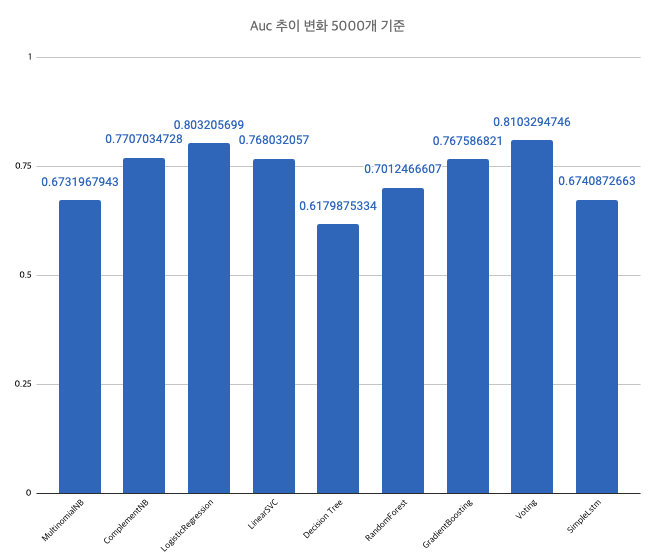

## 2. 10,000개 기준

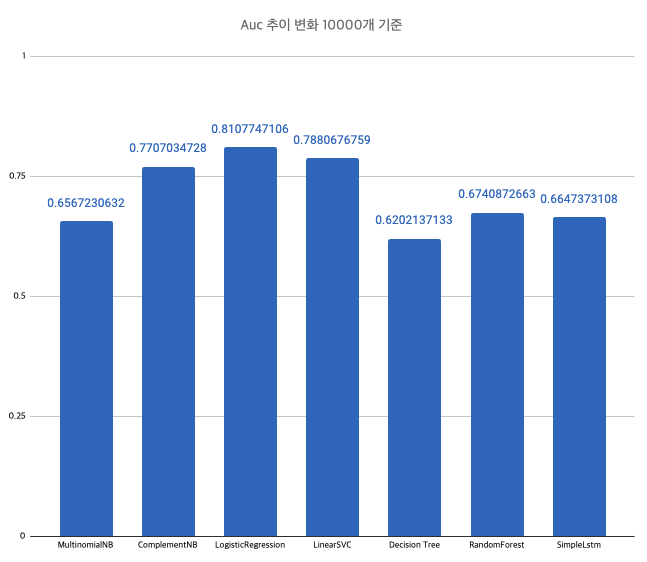

## 3. 25,000개 기준
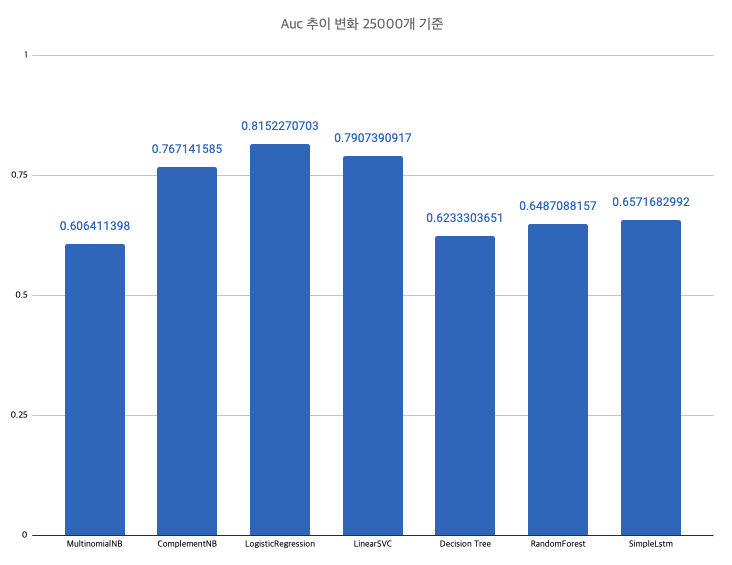